# Add the lasa.py file in same directory as the jupyter notebook

In [22]:
!pip install gmr
import gmr
import matplotlib.pyplot as plt
import numpy as np

from lasa import load_lasa

## Helper Functions for plotting and loading data

In [23]:
def plot_curves(x, show_start_end=True, **kwargs):
    """
    plots 2d curves of trajectories

    params:
        x: array of shape (number of curves,n_steps_per_curve,2)
    """
    if show_start_end:
        start_label, end_label = "start", "end"
    else:
        start_label, end_label = None, None
    for t in range(x.shape[0]):
        plt.scatter(x[t][0, 0], x[t][0, 1], c="k", label=start_label)
        plt.scatter(x[t][-1, 0], x[t][-1, 1], c="b", label=end_label)
        plt.plot(x[t][:, 0], x[t][:, 1], **kwargs)
        if t == 0:
            kwargs.pop("label", None)
            start_label, end_label = None, None

    plt.legend()


def streamplot(f, x_axis=(0, 100), y_axis=(0, 100), n=1000, width=1, **kwargs):
    """
    helps visualizing the vector field.

    params:
        f: function to predict the velocities in DS(Dynamical system : x_dot = f(x),x of shape (n_points,2),x_dot of shape (n_points,2))
        x_axis: x axis limits
        y_axis: y axis limits
        n: number of points in each axis (so total n*n predictions happen)
        width: width of the vector
        **kwargs: goes into plt.streamplot
    """
    a, b = np.linspace(x_axis[0], x_axis[1], n), np.linspace(y_axis[0], y_axis[1], n)
    X, Y = np.meshgrid(a, b)
    X_test = np.stack([X, Y], axis=-1).reshape(-1, 2)
    Y_pred = f(X_test)
    U, V = np.split(Y_pred.reshape(n, n, 2), 2, axis=-1)
    U, V = U[..., 0], V[..., 0]
    speed = np.sqrt(U**2 + V**2)
    lw = width * speed / speed.max()
    plt.streamplot(X, Y, U, V, linewidth=lw, **kwargs)


# gets the velocity x_dot given x
def derivative(x):
    """
    difference method for calculating derivative

    params:
      x: array of shape (number of trajectories,number of timesteps,2)

    returns
      xd: array of shape (number of trajectories,number of timesteps,2)
    """
    xds = []

    for i in range(x.shape[0]):
        dt = 1 / (x[i].shape[0] - 1)
        xd = np.vstack((np.diff(x[i], axis=0) / dt, np.zeros((1, x[i].shape[1]))))
        v_factor = np.cos(np.linspace(0, np.pi / 2, len(xd))) ** 2
        xd = xd * (v_factor[..., None])
        xds.append(xd)
    xd = np.stack(xds)
    return xd


# loading the data and plotting
def load_data(letter):
    """
    gets the trajectories coresponding to the given letter

    params:
      letter: character in ["c","j","s"]

    returns:
      data: array of shape (number of trajectories,number of timesteps,2)
      x: array of shape(number of trajectories*number of timesteps,2)
      xd: array of shape(number of trajectories*number of timesteps,2)

    """
    letter2id = dict(c=2, j=6, s=24)
    assert letter.lower() in letter2id
    _, x, _, _, _, _ = load_lasa(letter2id[letter.lower()])
    xd = derivative(x)
    plot_curves(x)
    data = x
    x = x.reshape(-1, 2)
    xd = xd.reshape(-1, 2)
    plt.show()
    return data, x, xd

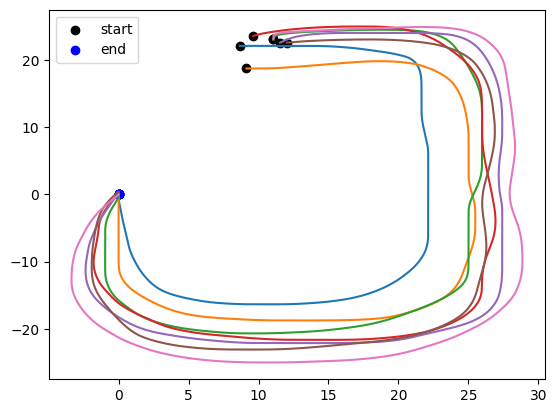

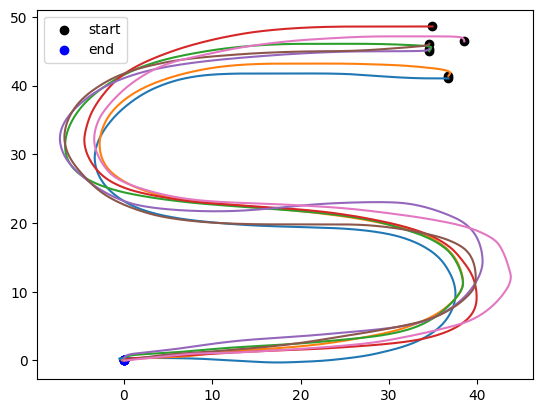

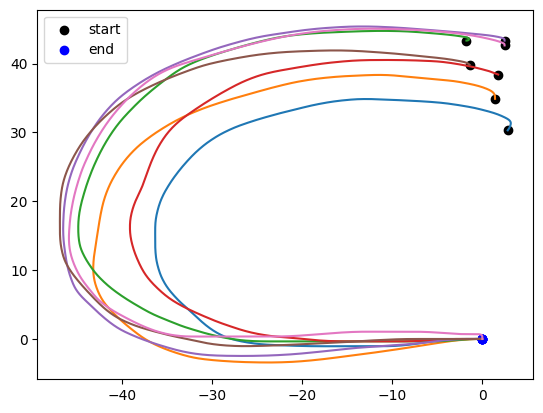

In [24]:
# letter should be one of c,j,s
data, x, xd = load_data("j")
data, x, xd = load_data("s")
data, x, xd = load_data("c")

# PART-1 : Linear Least Squares (LLS)

In [25]:
class LeastSquares:

    def __init__(self, lam=1e-2, bias=False):

        self.bias = bias
        self.lam = lam

    def fit(self, X, Y):
        """
        store the weight matrix into self.w

        self.w should be array of shape (3,2) if bias is enabled and
        (2,2) if bias is False


        params:
            X: data of shape (n_points,2)
            Y: X_dot of shape(n_points,2)
        """
        ########################
        # YOUR CODE HERE

        # If bias is enabled, add a column of ones to X.
        if self.bias:
            X_design = np.hstack([X, np.ones((X.shape[0], 1))])
        else:
            X_design = X

        # w = (X_design^T X_design + lam * I)^(-1) X_design^T Y
        d = X_design.shape[1]  # number of columns in design matrix
        self.w = np.linalg.inv(X_design.T @ X_design + self.lam * np.eye(d)) @ (
            X_design.T @ Y
        )

        ########################

    def predict(self, X):
        """
        returns prediction from the model X_dot

        params:
            X: array of shape (n_points,2)
        returns:
            predicted X_dot: array of shape (n_points,2)
        """
        ###########################
        # YOUR CODE HERE

        if self.bias:
            X_design = np.hstack([X, np.ones((X.shape[0], 1))])
        else:
            X_design = X
        return X_design @ self.w

        ###########################

    def ode_differential(self, x, t):
        """
        function used for rk4 simulation
        """
        return self.predict(x[None])[0]

    def rk4_sim(self, t0, t_end, x0, f, dt=1e-3):
        """
        simlution done with rk4

        Returns
        -------
        x : shape (n_steps,self.d)
        t : shape - (n_steps,)
        """
        # Calculate slopes
        x, t = x0, t0
        x_list, t_list = [x0], [t0]
        while t <= t_end:
            k1 = dt * f(x, t)
            k2 = dt * f(x + k1 / 2.0, t + dt / 2.0)
            k3 = dt * f(x + k2 / 2.0, t + dt / 2.0)
            k4 = dt * f(x + k3, t + dt)

            # Calculate new x and y
            x = x + 1.0 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
            t = t + dt
            x_list.append(x)
            t_list.append(t)

        return np.array(x_list), np.array(t_list)

    def imitate(self, x0, t_end=5):
        """
        imitation with new starting point

        Parameters
        ----------
        x0  - starting point - shape (self.d,)

        Returns
        -------
        x_rk4 - simulated data  - shape (n_steps,self.d)
        t_rk4 - time - shape (n_steps,)
        """
        f = self.ode_differential
        return self.rk4_sim(0, t_end, x0, f)

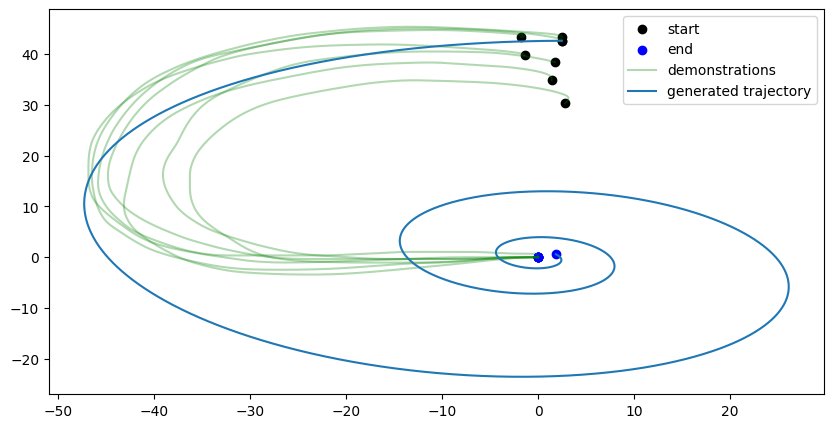

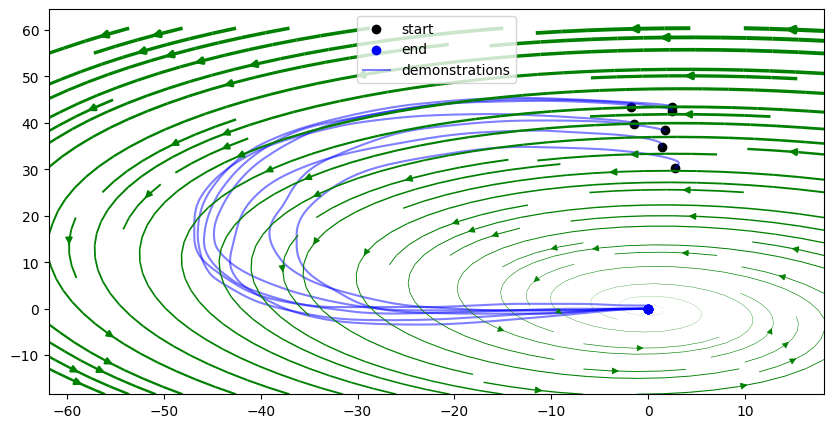

In [26]:
# fitting the model to data
model = LeastSquares(lam=0, bias=False)
model.fit(x, xd)

# starting point for imitation
x0 = data[6][0]
x_rk4, t_tk4 = model.imitate(x0, t_end=10)

# plots for generated trajectory
plt.figure(figsize=(10, 5))
plot_curves(data, alpha=0.3, c="g", label="demonstrations")
plot_curves(x_rk4[None], show_start_end=False, label="generated trajectory")

# vector field plot using stream line
plt.figure(figsize=(10, 5))
plot_curves(data, alpha=0.5, c="b", label="demonstrations")

streamplot(
    model.predict,
    x_axis=(min(x[:, 0]) - 15, max(x[:, 0]) + 15),
    y_axis=(min(x[:, 1]) - 15, max(x[:, 1]) + 15),
    width=3,
    color="g",
)

# Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1 Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try changing the bias parameter to True, Report and try to explain the changes in the graph. \\
Ans:

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try changing the bias parameter to True, Report and try to explain the changes in the graph. \\
Ans:

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try changing the bias parameter to True, Report and try to explain the changes in the graph. \\
Ans:

In [27]:
####################
# YOUR CODE HERE FOR ANSWERING THE ABOVE QUESTIONS


def fit_least_squares(letter, lam=0, bias=False):
    # load data
    data, x, xd = load_data(letter)

    # fitting the model to data
    model = LeastSquares(lam=lam, bias=bias)
    model.fit(x, xd)

    # starting point for imitation
    x0 = data[6][0]
    x_rk4, t_tk4 = model.imitate(x0, t_end=10)

    # plots for generated trajectory
    plt.figure(figsize=(10, 5))
    plot_curves(data, alpha=0.3, c="g", label="demonstrations")
    plot_curves(x_rk4[None], show_start_end=False, label="generated trajectory")

    # vector field plot using stream line
    plt.figure(figsize=(10, 5))
    plot_curves(data, alpha=0.5, c="b", label="demonstrations")

    streamplot(
        model.predict,
        x_axis=(min(x[:, 0]) - 15, max(x[:, 0]) + 15),
        y_axis=(min(x[:, 1]) - 15, max(x[:, 1]) + 15),
        width=3,
        color="g",
    )


def fit_least_squares_on_dataset(letter):
    print(f"Dataset: {letter}")
    fit_least_squares(letter, lam=0, bias=False)
    fit_least_squares(letter, lam=0, bias=True)
    return None


####################

### Dataset 'c'

Dataset: c


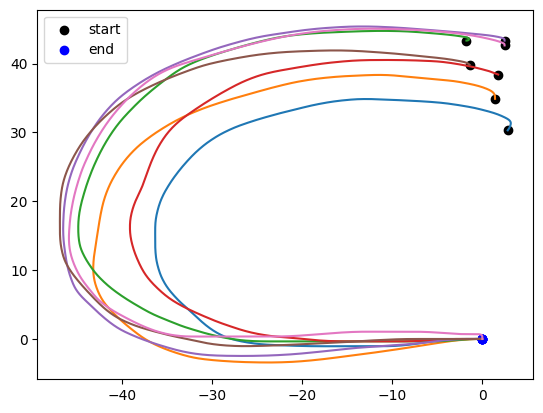

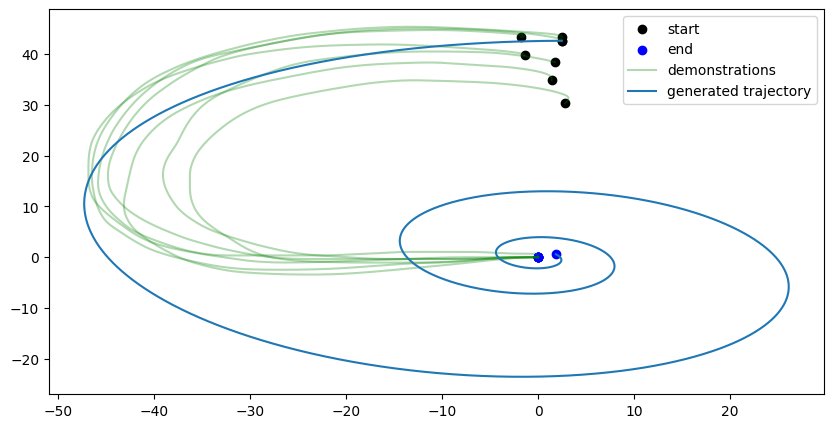

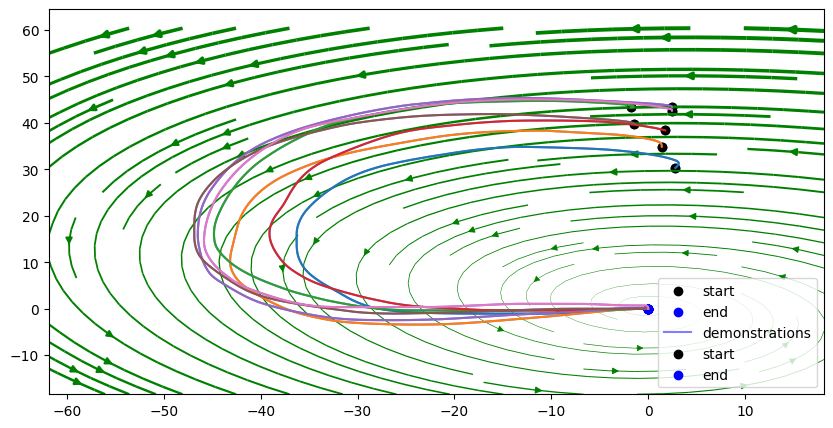

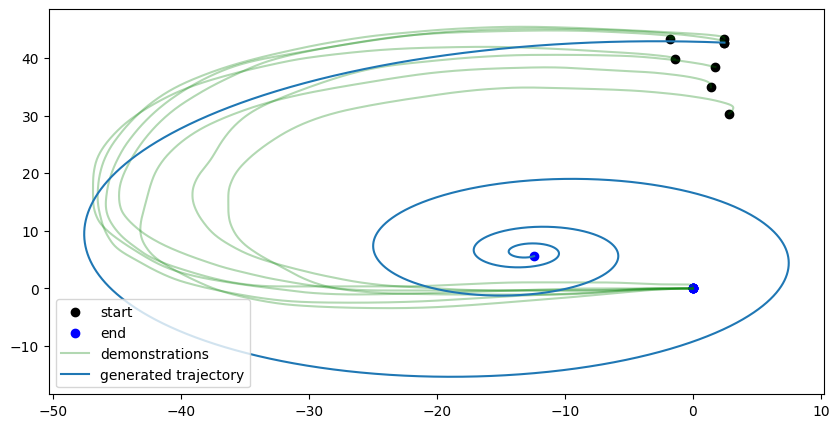

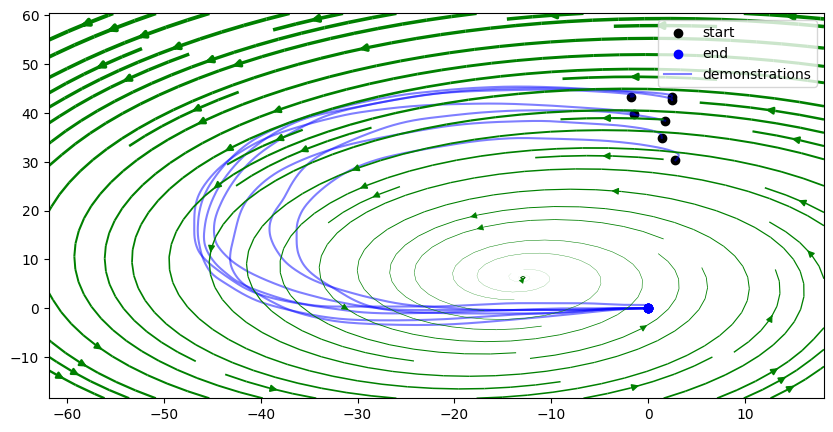

In [28]:
fit_least_squares_on_dataset("c")

Dataset 'c'

1. GAS Point

The system does have a GAS point.
This can be seen by observing that the end point in the generated trajectory is very close to the end point in the demonstrated trajectory.
The trajectory converges to the endpoint.

2. Bias Parameter

With bias, the system does have a GAS point.
The addition of bias creates an offset in the trajectory's end points.
This produces a better fit in this dataset, since the trajectories are aligned up better, as seen in the vector field.


### Dataset 'j'

Dataset: j


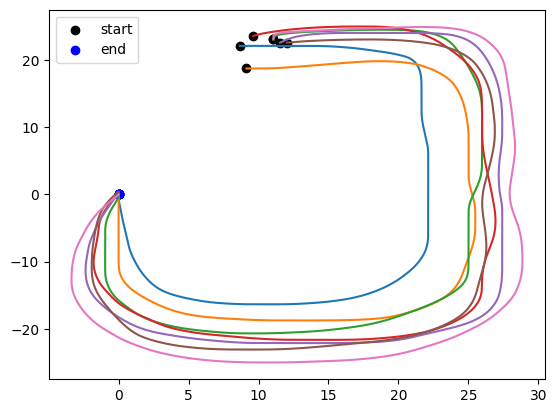

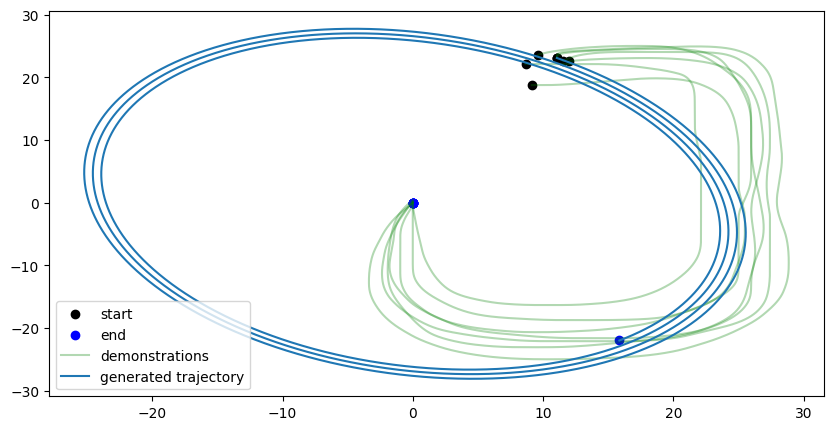

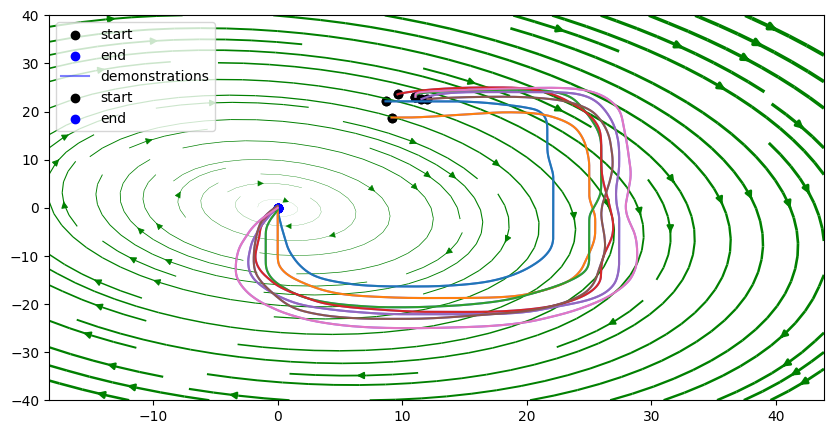

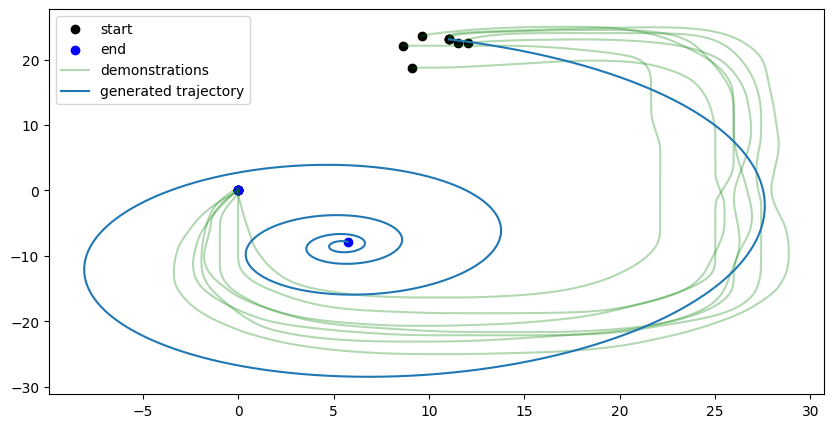

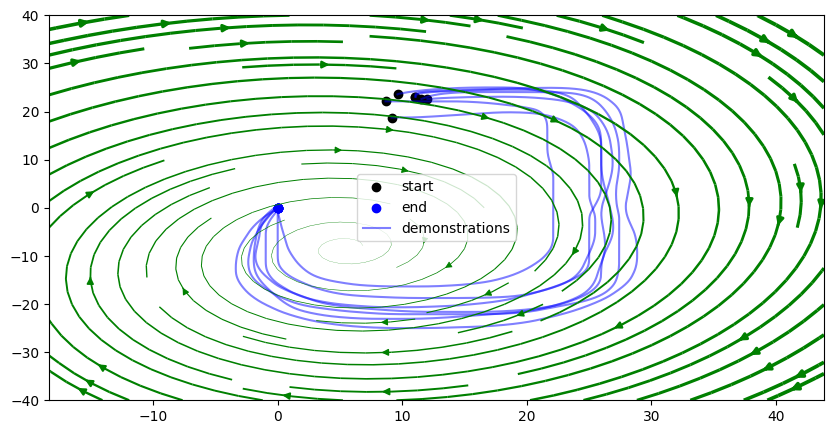

In [29]:
fit_least_squares_on_dataset("j")

Dataset 'j'

1. GAS Point

The system does have a GAS point.
This can be seen by observing that the end point in the generated trajectory is very close to the end point in the demonstrated trajectory.
The trajectory converges to the endpoint.
Although in this case, the convergence seems rather slower than in the previous "c" dataset.

2. Bias Parameter

With bias, the system does have a GAS point.
The addition of bias creates an offset in the trajectory's end points.
This produces a better fit in this dataset, since the trajectories are aligned up better, as seen in the vector field, although the fit is still bad.


### Dataset 's'

Dataset: s


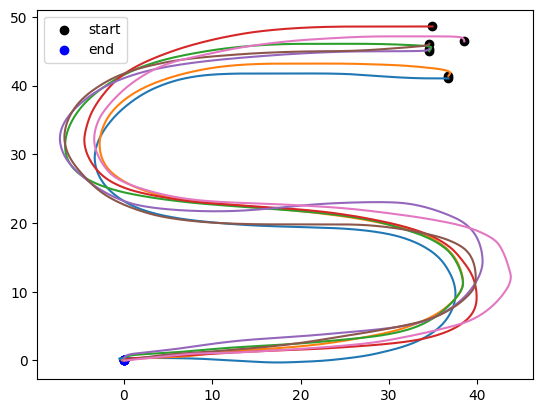

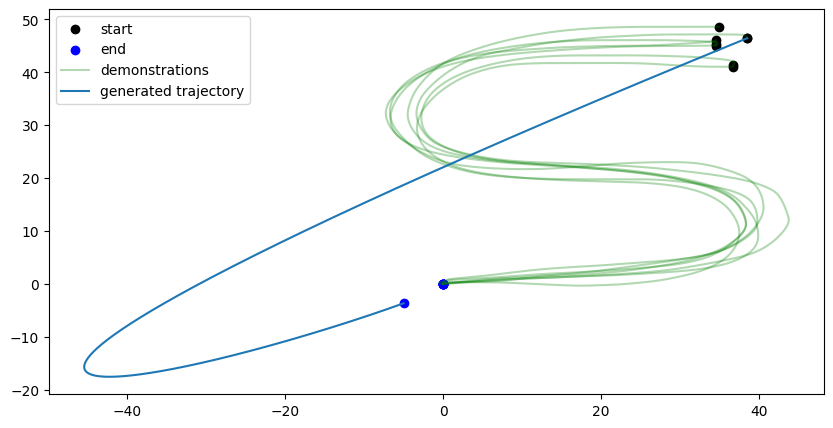

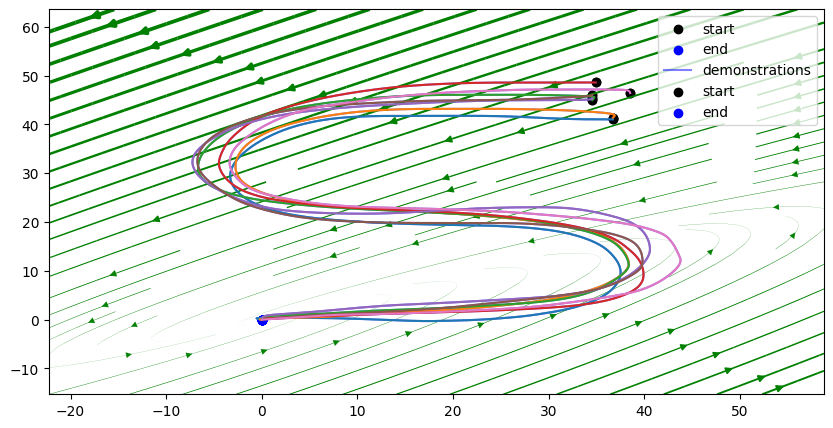

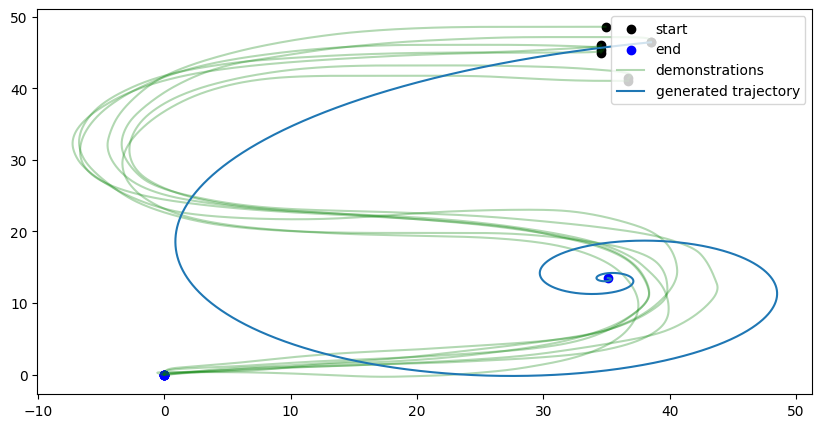

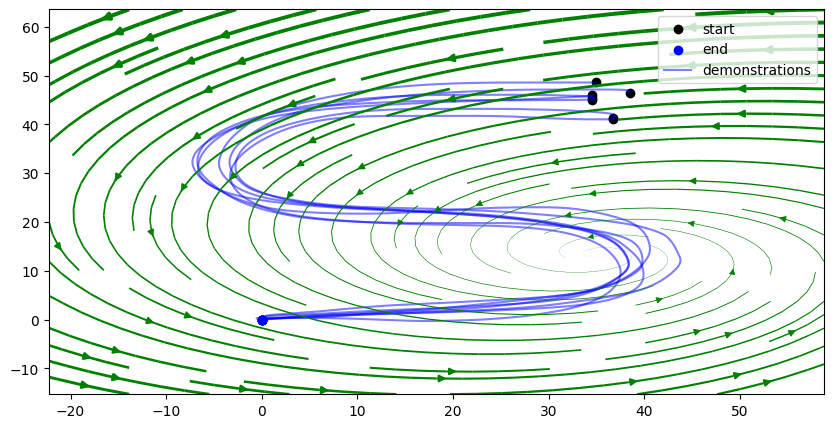

In [30]:
fit_least_squares_on_dataset("s")

Dataset 's'

1. GAS Point

The system does have a GAS point.
This can be seen by observing that the end point in the generated trajectory is very close to the end point in the demonstrated trajectory.
The trajectory converges to the endpoint.
It can be observed that the fit is very bad in this case.

2. Bias Parameter

With bias, the system does have a GAS point.
The addition of bias creates an offset in the trajectory's end points.
This produces a better fit in this dataset, since the trajectories are aligned up better, as seen in the vector field, better than without bias.
Although there are some initial points in the vector field starting from which, the convergence is bad.


# PART-2 Locally Weighted Regression (LWR)

[GMR](https://alexanderfabisch.github.io/gmr/#gmr.MVN) is handy package that helps us to deal with gaussian distributions. \\
some notable methods that you can use are *from_samples*,*to_norm_factor_and_exponents*,*condition*. \\
we can also visualize gaussians with *plot_error_ellipse* function


In [31]:
def init_gaussians(y, n=3):
    """
    initializes the gaussian based on time fragmentaion

    params:
        y : array of shape (number of trajectories,number of timesteps,2)
    returns:
        mvns: list of gmr.MVN() initialized objects
    """
    l = y.shape[1] // n
    y_split = [
        y[:, i * l :] if i == n - 1 else y[:, i * l : (i + 1) * l] for i in range(n)
    ]
    mvns = [gmr.MVN().from_samples(x.reshape(-1, 2)) for x in y_split]
    splot = plt.subplot(111)
    plot_curves(y)
    for mvn in mvns:
        gmr.plot_error_ellipse(splot, mvn, factors=[1])
    return mvns

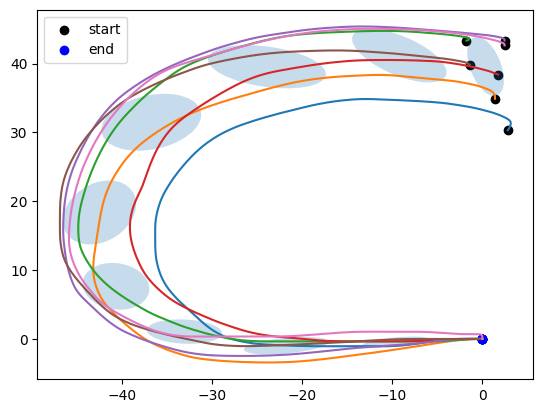

In [32]:
# basis functions initializes with gaussians from data
mvns = init_gaussians(data, 10)

In [33]:
class LWR:
    def __init__(self, mvns, bias=True):
        """
        gaussians for weights
        params:
          mvns: list of gaussians
          bias: x@weight+bias
        """
        self.mvns = mvns
        self.bias = bias

    def fit(self, X, Y):
        """
        gets the weight matrix into self.ws

        self.ws is a list of length len(self.mvns), with each element as weight matrix (3,2) if bias is True, (2,2) if bias is False

        params:
            X: data of shape (n_points,2)
            Y: X_dot of shape(n_points,2)
        """
        ################################
        # YOUR CODE HERE (you can use gmr package or can also write your own functions)

        self.ws = []
        for mvn in self.mvns:
            gmr_model = gmr.GMR(mvn)
            gmr_model.fit(X, Y)
            self.ws.append(gmr_model.get_weights())

        ################################

    def predict(self, X):
        """
        returns prediction from the model =>X_dot

        merge the multple predictions from different weight matrices.

        params:
            X: array of shape (n_points,2)
        returns:
            predicted X_dot: array of shape (n_points,2)
        """
        ################################
        # YOUR CODE HERE (you can use gmr package or can also write your own functions)

        self.ws = []

        for mvn in self.mvns:
            gmr_model = gmr.GMR(mvn)
            gmr_model.fit(X, Y)
            self.ws.append(gmr_model.get_weights())

        ################################

    def ode_differential(self, x, t):
        """
        function used for rk4 simulation
        """
        return self.predict(x[None])[0]

    def rk4_sim(self, t0, t_end, x0, f, dt=1e-3):
        """
        simlution done with rk4

        Returns
        -------
        x : shape (n_steps,self.d)
        t : shape - (n_steps,)
        """
        # Calculate slopes
        x, t = x0, t0
        x_list, t_list = [x0], [t0]
        while t <= t_end:
            k1 = dt * f(x, t)
            k2 = dt * f(x + k1 / 2.0, t + dt / 2.0)
            k3 = dt * f(x + k2 / 2.0, t + dt / 2.0)
            k4 = dt * f(x + k3, t + dt)

            # Calculate new x and y
            x = x + 1.0 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
            t = t + dt
            x_list.append(x)
            t_list.append(t)

        return np.array(x_list), np.array(t_list)

    def imitate(self, x0, t_end=5):
        """
        imitation with new starting point

        Parameters
        ----------
        x0  - starting point - shape (self.d,)

        Returns
        -------
        x_rk4 - simulated data  - shape (n_steps,self.d)
        t_rk4 - time - shape (n_steps,)
        """
        f = self.ode_differential
        return self.rk4_sim(0, t_end, x0, f)

In [34]:
# fitting the model to data
model = LWR(mvns, False)
model.fit(x, xd)

# starting point for imitation
x0 = data[6][0]
x_rk4, t_tk4 = model.imitate(x0, t_end=10)

# plots for generated trajectory
plt.figure(figsize=(10, 5))
plot_curves(data, alpha=0.3, c="g", label="demonstrations")
plot_curves(x_rk4[None], show_start_end=False, label="generated trajectory")

# vector field plot using stream line
plt.figure(figsize=(10, 5))
plot_curves(data, alpha=0.5, c="b", label="demonstrations")

streamplot(
    model.predict,
    x_axis=(min(x[:, 0]) - 15, max(x[:, 0]) + 15),
    y_axis=(min(x[:, 1]) - 15, max(x[:, 1]) + 15),
    width=3,
    color="g",
)

AttributeError: module 'gmr' has no attribute 'GMR'

# Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

In [ ]:
####################
# YOUR CODE HERE FOR ANSWERING THE ABOVE QUESTIONS
####################

***for "S" Dataset*** \\
Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans:

In [ ]:
####################
# YOUR CODE HERE FOR ANSWERING THE ABOVE QUESTIONS
####################

# LLS vs LWR

Q1.which one generalizes better? Why? \\
Ans:

Q2.Does any one of the algorithms gives gaurentees of global attracter? \\
Ans:


# Submission details

please submit the copy of this file with the naming convention **SRNO(5digit)_Assignment3.ipynb**